## Text Classification of Movie Plot Summaries to Predict Movie Genre

Movies are one of the most common forms of entertainment for people. Humans can understand the genre of a movie by reading the plot summary, but machines cannot. Therefore, categorizing movies by their genre based on the plot description is essential for creating predictive models that are capable of automatically determining the genre of a movie when the plot is provided. Assigning movies to predefined genres is important because it allows online platforms to recommend movies to users based on their preferences, while also enabling users to search for movies more quickly and with greater focus.

### Objective and State of The Art

The goal of this work is to predict the genre of a movie based on its plot description. We assume that each movie can belong to exactly one genre (multi-class classification). Additionally, the most popular movie genres will be used to create classifiers that, after training on the dataset, will be able to predict movie genres from plot descriptions that they haven't been trained on.
We will train a deep learning model with a Long Short-Term Memory (LSTM) architecture and one with a 1D Convolutional Neural Networks (CNNs1D) architecture. Furthermore, we will train a statistical machine learning model using the Multinomial Naive Bayes classifier and compare the performance of these three models.

### Related Work

Over time, a large number of studies have been published aiming to solve the above problem. The architecture most commonly used is Bidirectional LSTMs. Additionally, a variety of machine learning algorithms have been employed, such as Support Vector Machines, Multinomial Naive Bayes, Random Forests, and others.

### Overview of methods used

*    Text Cleaning
  
*    Text Vectorization
*    Word Embeddings
*    LSTM Model
*    CNN Model
*    Multinomial Naive Bayes

## Data Exploration and Visualization

Initially, before constructing, training, and evaluating the neural network, the data needs to be loaded, processed, and visualized. In this example, we will use the wiki_movie_plots_deduped dataset, which contains information about movies such as the title, genre, release date, plot description, and more. The goal is to build a model that will predict the genre of a movie based on its plot description. The data is contained in a CSV file located in the same folder as the Jupyter notebook. To load the data, we will use the read_csv function from the pandas library.

In [1]:
import pandas as pd
import numpy as np

data = pd.read_csv('wiki_movie_plots_deduped.csv')

In [2]:
data.head()

,Release Year,Title,Origin/Ethnicity,Director,Cast,Genre,Wiki Page,Plot
0,1901,Kansas Saloon Smashers,American,Unknown,NaN,unknown,https://en.wikipedia.org/wiki/Kansas_Saloon_Sm...,"A bartender is working at a saloon, serving dr..."
1,1901,Love by the Light of the Moon,American,Unknown,NaN,unknown,https://en.wikipedia.org/wiki/Love_by_the_Ligh...,"The moon, painted with a smiling face hangs ov..."
2,1901,The Martyred Presidents,American,Unknown,NaN,unknown,https://en.wikipedia.org/wiki/The_Martyred_Pre...,"The film, just over a minute long, is composed..."
3,1901,"Terrible Teddy, the Grizzly King",American,Unknown,NaN,unknown,"https://en.wikipedia.org/wiki/Terrible_Teddy,_...",Lasting just 61 seconds and consisting of two ...
4,1902,Jack and the Beanstalk,American,"George S. Fleming, Edwin S. Porter",NaN,unknown,https://en.wikipedia.org/wiki/Jack_and_the_Bea...,The earliest known adaptation of the classic f...


**We are interested in predicting the genre of the movie based on the plot summary, so we will keep only the Genre and Plot columns.**

In [3]:
data = data[['Genre', 'Plot']]
data.head()

,Genre,Plot
0,unknown,"A bartender is working at a saloon, serving dr..."
1,unknown,"The moon, painted with a smiling face hangs ov..."
2,unknown,"The film, just over a minute long, is composed..."
3,unknown,Lasting just 61 seconds and consisting of two ...
4,unknown,The earliest known adaptation of the classic f...


In [4]:
data.duplicated()

0        False
1        False
2        False
3        False
4        False
         ...  
34881    False
34882    False
34883    False
34884    False
34885    False
Length: 34886, dtype: bool

In [5]:
data['Genre'].unique()

array(['unknown', 'western', 'comedy', ...,
       'adventure, romance, fantasy film', 'ero',
       'horror romantic comedy'], dtype=object)

In [6]:
data['Genre'].value_counts()

Genre
unknown                          6083
drama                            5964
comedy                           4379
horror                           1167
action                           1098
                                 ... 
cbc-tv miniseries                   1
bio-drama                           1
national film board docudrama       1
cult drama                          1
horror romantic comedy              1
Name: count, Length: 2265, dtype: int64

In [7]:
data = data.loc[data['Genre'] != 'unknown']

In [8]:
data['Genre'].value_counts()[:10]

Genre
drama        5964
comedy       4379
horror       1167
action       1098
thriller      966
romance       923
western       865
crime         568
adventure     526
musical       467
Name: count, dtype: int64

**We will keep the 10 most frequent movie genres, since the dataset is higly unbalanced.**

In [9]:
data = data[data['Genre'].isin(['drama', 'comedy', 'horror', 'action', 'thriller', 'romance', 'western', 'crime', 'adventure', 'musical'])]
data = data.reset_index(drop=True) #to avoid the old index being added as a column 

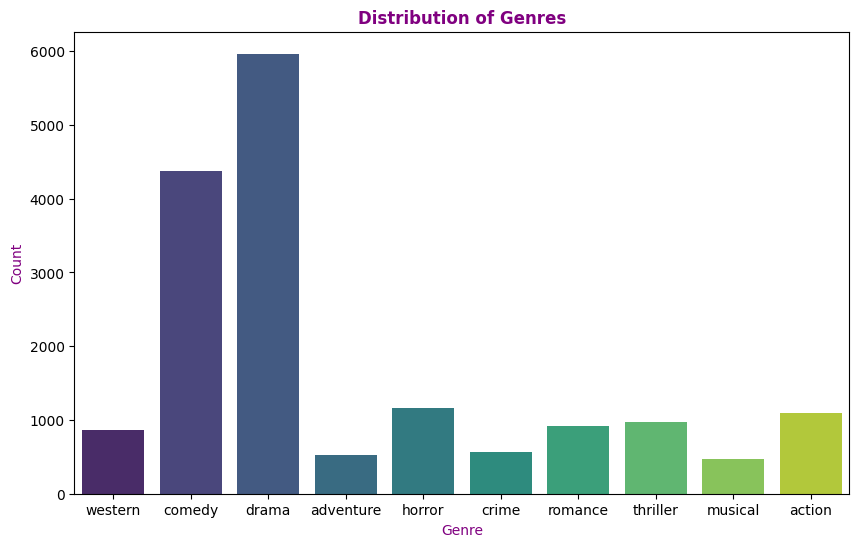

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10,6))
sns.countplot(data=data, x='Genre', palette='viridis')
plt.xlabel('Genre', color='purple')
plt.ylabel('Count', color='purple')
plt.title('Distribution of Genres', color='purple', fontweight='bold')
plt.show()

In the above chart, we can see the distribution of genres in the training set. We notice that the drama genre contains at least 5500 more observations than the crime, adventure, and musical genres. This imbalance could make it more challenging for the model to accurately predict the genres with fewer observations, as more data from the drama and comedy genres will be used during training.

In [11]:
data.to_csv('movies_cleaned.csv', index=False)

## Text Cleaning and Preprocessing

In the following section of code, appropriate preprocessing will be applied to the text data, which contains the plot descriptions of the movies, in order to make it suitable for training the models. The functions used are presented below:

* text_lowercase function: Converts all words in the text to lowercase.
* remove_numbers function: Removes numbers from the text.
* remove_brackets function: Removes brackets from the text.
* remove_punctuation function: Removes punctuation marks from the text.
* remove_special_characters function: Removes special characters from the text.
* remove_stopwords function: Performs tokenization on each text using the word_tokenize method from the nltk.tokenize module and removes stopwords using the nltk.corpus module.

In [12]:
print(data['Plot'][12])

An old woman sends a girl begging in the streets of Paris on a snowy evening. Callous revelers pass her by, and she falls asleep before one donor finally drops a golden Louis in her shoe. A gambler with a sure tip on roulette but no cash borrows the coin to win a fortune for the girl. She wakes, and the two miss each other wandering the streets until the gambler finds the girl dead.


In [13]:
import nltk
import string
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

In [14]:
def text_lowercase(text):
    return text.lower()

def remove_numbers(text):
    result = re.sub(r'\d+', '', text)
    return result

def remove_bracket(text):
    return re.sub('\[[^]]*\]', '', text)

def remove_punctuation(text):
    translator = str.maketrans('', '', string.punctuation)
    return text.translate(translator)

def remove_special_characters(text):
    pattern = r'[^a-zA-z0-9\s]'
    text=re.sub(pattern, '', text)
    return text

def remove_stopwords(text):
    stop_words = set(stopwords.words("english"))
    word_tokens = word_tokenize(text)
    word_tokens = [word for word in word_tokens if word not in stop_words]
    text = ' '.join(word_tokens) # rejoin tokens into a single string
    return text

In [15]:
def clean_text(text):
    text = text_lowercase(text)
    text = remove_numbers(text)
    text = remove_bracket(text)
    text = remove_punctuation(text)
    text = remove_special_characters(text)
    text = remove_stopwords(text)
    return text

In [16]:
data['Plot'] = data['Plot'].apply(clean_text)

In [17]:
print(data['Plot'][12])

old woman sends girl begging streets paris snowy evening callous revelers pass falls asleep one donor finally drops golden louis shoe gambler sure tip roulette cash borrows coin win fortune girl wakes two miss wandering streets gambler finds girl dead


We need to convert the categorical variable Genre into a one-hot encoding format so that it can be a valid input for the neural network. This is done by applying the LabelEncoder method from the preprocessing module of the sklearn library. The output of the LabelEncoder is then passed to the to_categorical method from the utils module of the Keras library, which returns the one-hot encoded representation of the Genre variable.

In [18]:
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
from tensorflow import keras

X = data['Plot']
y = data['Genre']


le = LabelEncoder()

y_enc = le.fit_transform(y)
y_label = tf.keras.utils.to_categorical(y_enc)

At this point, the dataset can be split into a training set (70%) and a test set (30%) from the original dataset. This way, the model will be trained on the training data and evaluated on the test data. By doing this, the model is assessed based on data it has never seen before, ensuring that the performance evaluation is unbiased. The train_test_split function from the model_selection module of the scikit-learn library will be used for this split.

In the dataset, some categories have fewer observations. If the split into train and test sets is done randomly, it is possible that categories with very few observations will be included in the train set, which would make it difficult to predict these categories accurately in the test set. This can be avoided by using the Stratification technique, which ensures that the data is split into train and test sets in such a way that the original distribution of each category is maintained in both sets. This way, the model will have better generalization and will produce more accurate predictions.

In [19]:
from sklearn.model_selection import train_test_split 

X_train, X_test, y_train, y_test = train_test_split(X, y_label, test_size=0.3, random_state=42, shuffle=True, stratify=y)

print("Number of Observations in the Data set:" , X.values.shape[0]) 
print("Number of Observations in Train set:", X_train.shape[0])
print("Number of Observations in Test set:" , X_test.shape[0])   

Number of Observations in the Data set: 16923
Number of Observations in Train set: 11846
Number of Observations in Test set: 5077


In [20]:
X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)

In [21]:
train_plot_lengths = np.array([ len(train_sample) for train_sample in X_train ])

print(f"Max Training Plot Length: {np.max(train_plot_lengths)}")
print(f"Min Training Plot Length: {np.min(train_plot_lengths)}")

Max Training Plot Length: 19834
Min Training Plot Length: 16


In [22]:
plot_lengths = np.array([len(train_sample) for train_sample in X_train])
percent_documents_under_500_words = np.sum(plot_lengths<=500)/X_train.shape[0]

print(f"Median Training Plot Length: {np.median(plot_lengths)}")
print(f"Percentage of Plots Under 500 words: {round(percent_documents_under_500_words*100, 2)}%")

Median Training Plot Length: 1050.0
Percentage of Plots Under 500 words: 27.51%


From the above code cell, we observe that the average length of the texts in the training set is 1050 words (note that the texts have already been cleaned of stopwords). **This length is excessively large considering that usually only 3-4 sentences are needed to clarify the genre of the movie.** For this reason, when each word is mapped to an integer (token), we will limit the text length to the last 500 words. Although this will result in some loss of information, logically, this information is likely to be unnecessary.

To examine the class balance in the training and test sets and confirm if stratification worked correctly during the train_test_split, we can measure the observations per class and create a bar plot for visualization. This way, we can verify if the stratification ensured that the class distribution was maintained properly across both sets.

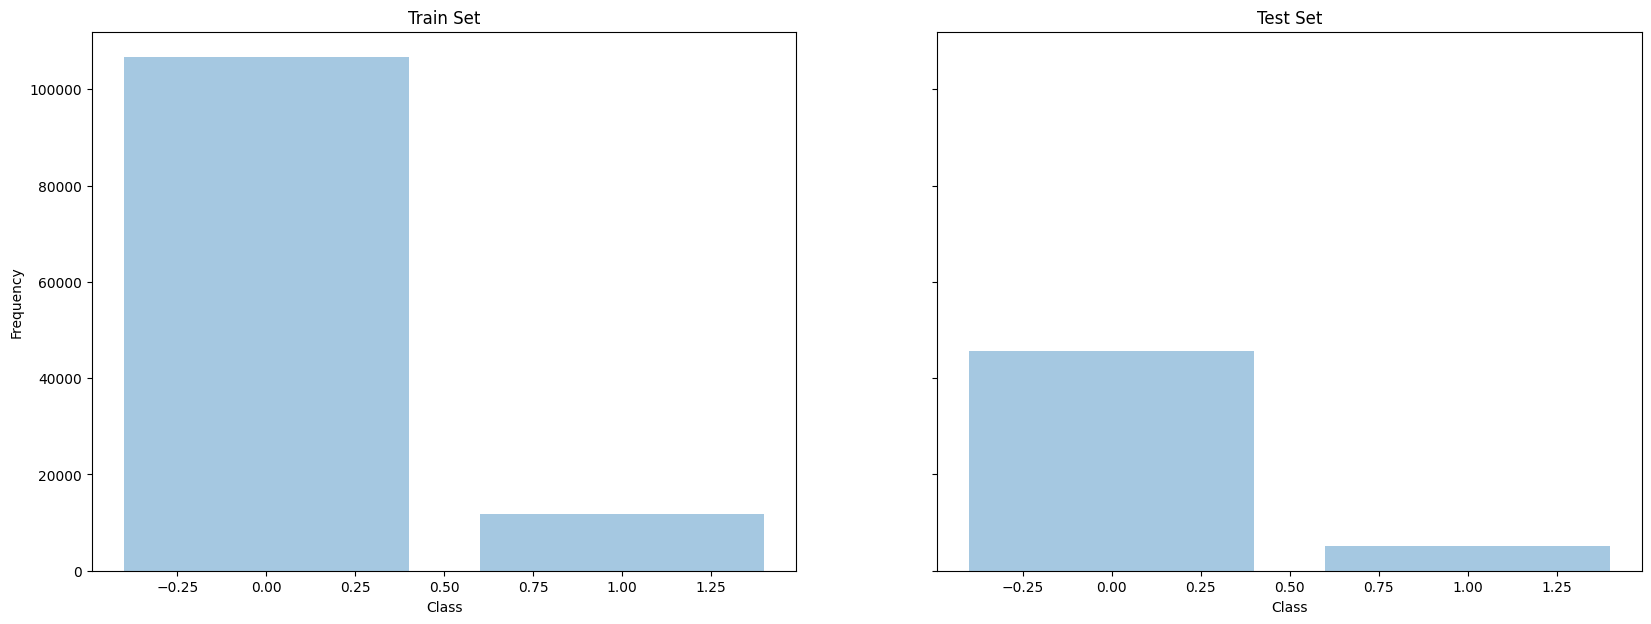

In [23]:
unq_values_train, counts_train = np.unique(y_train, return_counts=True)
unq_values_test, counts_test = np.unique(y_test, return_counts=True)


fig, axis = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(20,7))

axis[0].bar(unq_values_train, counts_train, align="center", alpha=0.4)
axis[0].set_xlabel("Class") 
axis[0].set_ylabel("Frequency") 
axis[0].set_title("Train Set")

axis[1].bar(unq_values_test, counts_test, align="center", alpha=0.4)
axis[1].set_xlabel("Class")
axis[1].set_title("Test Set")

plt.show()

## Text Vectorization

Next, we need to create a vector representation for each text so that the model can be trained. Here's the step-by-step approach:

Use the Tokenizer class from the Keras library to build the vocabulary for the corpus. The fit_on_texts method applies tokenization to the text data in the training set and returns a unique integer ID for each token (corresponding to a distinct word). The most frequent words in the corpus will have smaller IDs. The vocabulary will be created from the distinct words that appear in the training set.

Use the texts_to_sequences method to convert the text data into vector representations based on the words present in the vocabulary. Since the vector representations of texts usually have different lengths, padding will be used to ensure that all sequences have the same length. To apply padding, the pad_sequences method from Keras will be used.

The size of the vocabulary will be the 5000 most frequent words. Padding and truncation will be applied to the sequences so that all have a length of 500 words (the last 500 words from each text).

In [24]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(num_words=5000, oov_token='OOV')
tokenizer.fit_on_texts(X_train)

Since there may be words in the test set that do not appear in the training set (i.e., they are not part of the vocabulary), we use the oov_token parameter when initializing the Tokenizer object. This ensures that any out-of-vocabulary (OOV) words are assigned a unique integer ID, so they are not discarded during the prediction process.

The oov_token allows the model to handle words that were not seen during training by mapping them to a predefined token (typically an integer) and allowing the model to process them instead of ignoring them.

In [25]:
X_train_sequences = tokenizer.texts_to_sequences(X_train)
X_test_sequences = tokenizer.texts_to_sequences(X_test)

In [26]:
train_plot_lengths = np.array([ len(train_sample) for train_sample in X_train_sequences ])

print(f"Max Training Plot Length: {np.max(train_plot_lengths)}")
print(f"Median Training Plot Length: {np.median(train_plot_lengths)}")
print(f"Min Training Plot Length: {np.min(train_plot_lengths)}")

Max Training Plot Length: 2771
Median Training Plot Length: 148.0
Min Training Plot Length: 2


In [32]:
test_plot_lengths = np.array([ len(test_sample) for test_sample in X_test_sequences ])

print(f"Max Test Plot Length: {np.max(test_plot_lengths)}")
print(f"Median Test Plot Length: {np.median(test_plot_lengths)}")
print(f"Min Test Plot Length: {np.min(test_plot_lengths)}")

Max Test Plot Length: 1615
Median Test Plot Length: 146.0
Min Test Plot Length: 4


In [27]:
X_train_lstm = pad_sequences(X_train_sequences, padding='pre', truncating='pre', maxlen=500)
X_test_lstm = pad_sequences(X_test_sequences, padding='pre', truncating='pre', maxlen=500)

In [28]:
print(X_train_lstm.shape, X_test_lstm.shape)

(11846, 500) (5077, 500)


In [29]:
y_train_lstm = y_train
y_test_lstm = y_test

## Word Embeddings

In order to map the words from a 5000-dimensional space (one-hot encoding) to a 50-dimensional space (embedding space), the pre-trained GloVe model will be used. An embedding matrix will be created, where each word index is mapped to its corresponding embedding vector.

In [35]:
import numpy as np

embeddings_index = {}
f = open('glove.6B.50d.txt', encoding="utf-8")
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

In [36]:
embedding_dim = 50
vocab_size = 5000

embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in tokenizer.word_index.items():
    if i < vocab_size:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            # words not found in embedding index will be all-zeros.
            embedding_matrix[i] = embedding_vector

In [37]:
print(embedding_matrix.shape)

(5000, 50)


## Create, Train and Evaluate different Neural Networks

Once the data preprocessing is completed, the construction, training, and evaluation of the neural networks can begin. The different types of neural networks that will be used are: Long Short-Term Memory (LSTM) and Convolutional Neural Networks 1D (CNN 1D).

The desired architecture for each model will consist of a stack of layers that are connected sequentially. Therefore, the implementation can be carried out through the construction of a Sequential Model.

## LSTM

In [38]:
import tensorflow as tf
from keras.layers import Embedding, LSTM, Dense, Dropout
from keras.models import Sequential

vocab_size = 5000
embedding_dim = 50
maxlen = 500

lstm_model = Sequential()
lstm_model.add(Embedding(vocab_size, embedding_dim, 
                         weights=[embedding_matrix], 
                         input_length=maxlen, 
                         trainable=False)),
lstm_model.add(LSTM(128, return_sequences=True)),
lstm_model.add(LSTM(64)),
lstm_model.add(Dense(128, activation='relu')),
lstm_model.add(Dropout(0.5)),
lstm_model.add(Dense(10, activation='softmax'))

C:\Users\UserX\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In the code above, the created model can be observed. Initially, the Embedding layer is added, which contains the embedding matrix that was created using the pre-trained GloVe model. Specifically, this layer first performs a one-hot encoding of the documents into a matrix of size 11846×5000 (Document Size × Vocabulary Size), and then maps these 5000 dimensions to 50.

The vectors in the Embedding Layer capture the semantics of the words, as words with similar meanings tend to have similar vectors in the embedding space.

Next, two consecutive LSTM layers with 128 and 64 neurons in each internal cell are added.

The output from the last LSTM layer enters a Fully Connected (Dense) layer with 128 neurons and uses the Rectified Linear Unit (ReLU) activation function.

Then, Dropout is applied, which deactivates 50% of the neurons in the previous layer by assigning a value of 0 to the results of the activation functions.

The output layer is another Fully Connected (Dense) layer with 10 neurons and uses the softmax activation function. The output neurons return the probability of each of the 10 classes, and each input will correspond to the class with the highest probability.

In [39]:
lstm_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

The Categorical Crossentropy loss function is chosen because this is a multi-class classification problem, where each input (movie plot description) can belong to one of several classes (genres). Categorical Crossentropy is commonly used for problems where each sample belongs to one class from a set of multiple classes.

The Adam optimizer is selected as the optimization algorithm. Adam (short for Adaptive Moment Estimation) is an advanced optimization algorithm that computes adaptive learning rates for each parameter. It combines the advantages of both AdaGrad and RMSProp, making it very popular for training deep learning models due to its efficiency and robustness.

Additionally, Accuracy will be computed during the training process. This is a standard metric for classification problems, as it measures the percentage of correct predictions made by the model out of all the predictions

Now, the model training can begin using the fit method. The training will proceed for 20 epochs, with a batch size of 32. A validation set will be provided via the validation_split parameter, set to 20% of the training data, so the model’s performance can be evaluated on data it hasn't seen during training.

During training, the Early Stopping technique will be applied to avoid overfitting. Specifically, the training will stop if the model's validation loss does not improve for 2 consecutive epochs. This helps to prevent the model from learning noise in the training data, ensuring that it generalizes better to unseen data.

Additionally, the restore_best_weights=True parameter ensures that the model's weights are reverted to the state where the validation loss was at its minimum. This means that the weights stored at the epoch with the lowest validation_loss will be used as the final model weights, providing the best performance on the validation set.

In [40]:
from keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

epochs = 20
batch_size = 32

history = lstm_model.fit(X_train_lstm, y_train_lstm, validation_split=0.2, epochs=epochs, batch_size=batch_size, callbacks=[early_stopping])

Epoch 1/20
297/297 ━━━━━━━━━━━━━━━━━━━━ 342s 1s/step - accuracy: 0.3261 - loss: 1.9326 - val_accuracy: 0.3599 - val_loss: 1.7872
Epoch 2/20
297/297 ━━━━━━━━━━━━━━━━━━━━ 251s 844ms/step - accuracy: 0.3505 - loss: 1.8074 - val_accuracy: 0.3578 - val_loss: 1.7332
Epoch 3/20
297/297 ━━━━━━━━━━━━━━━━━━━━ 253s 851ms/step - accuracy: 0.3712 - loss: 1.7259 - val_accuracy: 0.4046 - val_loss: 1.6243
Epoch 4/20
297/297 ━━━━━━━━━━━━━━━━━━━━ 248s 834ms/step - accuracy: 0.4057 - loss: 1.6081 - val_accuracy: 0.4519 - val_loss: 1.5224
Epoch 5/20
297/297 ━━━━━━━━━━━━━━━━━━━━ 249s 837ms/step - accuracy: 0.4383 - loss: 1.5447 - val_accuracy: 0.4468 - val_loss: 1.5036
Epoch 6/20
297/297 ━━━━━━━━━━━━━━━━━━━━ 249s 840ms/step - accuracy: 0.4695 - loss: 1.4840 - val_accuracy: 0.4776 - val_loss: 1.4240
Epoch 7/20
297/297 ━━━━━━━━━━━━━━━━━━━━ 253s 850ms/step - accuracy: 0.4653 - loss: 1.4300 - val_accuracy: 0.4789 - val_loss: 1.4127
Epoch 8/20
297/297 ━━━━━━━━━━━━━━━━━━━━ 252s 849ms/step - accuracy: 0.4927 - lo

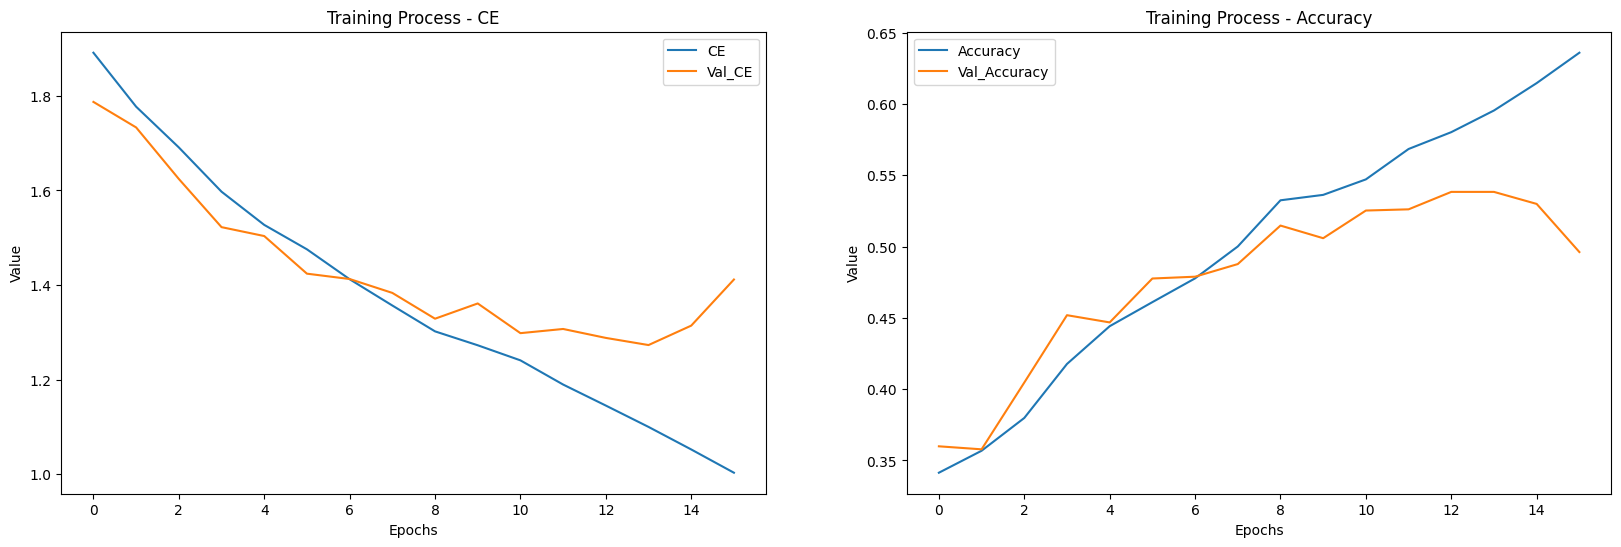

In [42]:
import matplotlib.pyplot as plt

fig, axis = plt.subplots(nrows=1,ncols=2, figsize=(20,6))

axis[0].plot(history.epoch, history.history['loss']) 
axis[0].plot(history.epoch, history.history['val_loss']) 
axis[0].set_xlabel("Epochs")
axis[0].set_ylabel("Value") 
axis[0].legend(["CE", "Val_CE"]) 
axis[0].set_title("Training Process - CE") 

axis[1].plot(history.epoch, history.history['accuracy'])
axis[1].plot(history.epoch, history.history['val_accuracy'])
axis[1].set_xlabel("Epochs") 
axis[1].set_ylabel("Value") 
axis[1].legend(["Accuracy", "Val_Accuracy"])
axis[1].set_title("Training Process - Accuracy")
plt.show()

In [43]:
# Save the model
lstm_model.save('lstm-model-16-epochs.h5')

In [44]:
y_pred = lstm_model.predict(X_test_lstm)

159/159 ━━━━━━━━━━━━━━━━━━━━ 40s 249ms/step


In [47]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

test_accuracy_lstm = accuracy_score(y_test_lstm.argmax(axis=1), y_pred.argmax(axis=1))

print("The Accuracy of the LSTM Model on the test data is", test_accuracy_lstm)

The Accuracy of the LSTM Model on the test data is 0.5446129604096908


**We observe that the model's accuracy on the training dataset is 54.4%. However, because there is class imbalance, it is necessary to calculate additional evaluation metrics to assess how well the model predicts each class.**

In [48]:
print(classification_report(y_test_lstm.argmax(axis=1), y_pred.argmax(axis=1), 
                            target_names=['Action', 'Adventure', 'Comedy', 'Crime', 'Drama', 'Horror', 'Musical', 'Romance', 'Thriller', 'Western']))

              precision    recall  f1-score   support

      Action       0.46      0.48      0.47       329
   Adventure       0.35      0.27      0.30       158
      Comedy       0.55      0.63      0.59      1314
       Crime       0.26      0.32      0.29       170
       Drama       0.58      0.62      0.60      1789
      Horror       0.62      0.74      0.67       350
     Musical       0.47      0.13      0.20       140
     Romance       0.43      0.23      0.30       277
    Thriller       0.40      0.12      0.19       290
     Western       0.64      0.77      0.70       260

    accuracy                           0.54      5077
   macro avg       0.48      0.43      0.43      5077
weighted avg       0.53      0.54      0.53      5077



**The model shows very good recall for the Horror and Western categories, even though they have a very small number of observations.**

**The accuracy of the model is better for the Drama, Comedy, Horror, and Western categories. The model correctly classifies over 50% of the observations it predicts belong to these categories.**

**ΌRegarding the most popular category (Drama), the model correctly classifies 62% of the films that truly belong to this category. However, the accuracy is lower - the model has correctly predicted 58% of the films that it predicted belong to the Drama category.**

**The model shows the lowest recall for the Thriller category, correctly classifying only 12% of the films in this category, and the lowest accuracy for the Crime category (only 26% of the films it predicts to belong to this category are correctly classified).**

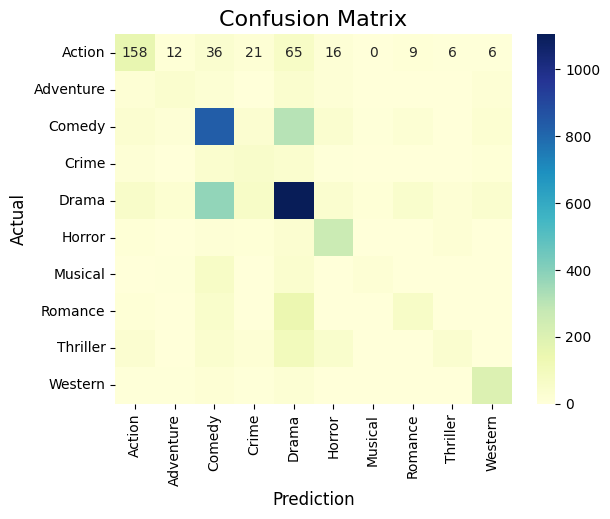

array([[ 158,   12,   36,   21,   65,   16,    0,    9,    6,    6],
       [  21,   42,   22,    1,   39,   15,    0,    0,    0,   18],
       [  31,   14,  831,   32,  308,   38,    8,   24,    2,   26],
       [  15,    1,   40,   54,   43,    5,    0,    0,    2,   10],
       [  58,   29,  379,   62, 1104,   38,   11,   46,   19,   43],
       [   9,    3,   14,    9,   33,  259,    1,    1,   20,    1],
       [   1,    7,   67,    2,   39,    1,   18,    2,    0,    3],
       [  10,    3,   48,    1,  145,    2,    0,   64,    3,    1],
       [  34,    3,   42,   21,  103,   46,    0,    2,   35,    4],
       [   5,    5,   19,    5,   25,    1,    0,    0,    0,  200]],
      dtype=int64)

In [49]:
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test_lstm.argmax(axis=1), y_pred.argmax(axis=1))

sns.heatmap(cm, annot=True, fmt='d', cmap='YlGnBu', xticklabels=['Action', 'Adventure', 'Comedy', 'Crime', 'Drama', 'Horror', 'Musical', 'Romance', 'Thriller', 'Western'],
            yticklabels=['Action', 'Adventure', 'Comedy', 'Crime', 'Drama', 'Horror', 'Musical', 'Romance', 'Thriller', 'Western'])
plt.xlabel('Prediction',fontsize=12)
plt.ylabel('Actual',fontsize=12)
plt.title('Confusion Matrix',fontsize=16)
plt.show()

cm

## CNN 1D

In [51]:
X_train_cnn = X_train_lstm
X_test_cnn = X_test_lstm
y_train_cnn = y_train_lstm
y_test_cnn = y_test_lstm

In [61]:
from keras.layers import Embedding, Conv1D, MaxPooling1D, Dense, Dropout, Flatten
from keras.models import Sequential

vocab_size = 5000
embedding_dim = 50
maxlen = 500
cnn_model = Sequential()
cnn_model.add(Embedding(vocab_size, embedding_dim, 
                         weights=[embedding_matrix], 
                         input_length=maxlen, 
                         trainable=False)),
cnn_model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu')),
cnn_model.add(MaxPooling1D(pool_size=2)),
cnn_model.add(Conv1D(filters=64, kernel_size=3, padding='same', activation='relu')),
cnn_model.add(MaxPooling1D(pool_size=2)),
cnn_model.add(Flatten()),
cnn_model.add(Dropout(rate=0.5)),
cnn_model.add(Dense(100, activation='relu')),
cnn_model.add(Dense(10, activation='softmax'))

In the code cell above, a model is created using one-dimensional Convolutional Neural Networks (Conv1D). Specifically, the model consists of:

* A Conv1D layer with 32 filters and a filter size of 3. This means the model will look at 3 words at a time. The padding parameter is used so that the output (after the convolution operation) has the same size as the input. Additionally, the Rectified Linear Unit (ReLU) activation function is used to introduce non-linearity into the model, as the convolution operation is a linear operation.

* A MaxPooling1D layer follows, which selects the maximum value from the result of the convolution for each 2-sized window, effectively reducing the size of the output from the convolution layer by half. Since each document has a fixed size of 500 words, after the pooling layer, the size of the document becomes 250.

* Another Conv1D layer with 64 filters and a filter size of 3 follows.

* Another MaxPooling1D layer follows, further reducing the length of the convolution from the previous Conv1D layer by half.

* The output of the final MaxPooling layer consists of 64 channels (filters), where each channel is a vector of 125 dimensions. This output is flattened using the Flatten layer, meaning each channel is placed next to the other to form a single vector of 8000 dimensions. This vector then passes through a Dropout layer, which drops 50% of its inputs, and then it is fed into a fully connected layer with 100 neurons and ReLU activation.

* Finally, the output from the previous layer is fed into the output layer, which has 10 neurons and uses the softmax activation function.

In [62]:
cnn_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [63]:
from keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

epochs = 20
batch_size = 32

history = cnn_model.fit(X_train_cnn, y_train_cnn, validation_split=0.2, epochs=epochs, batch_size=batch_size, callbacks=[early_stopping])

Epoch 1/20
297/297 ━━━━━━━━━━━━━━━━━━━━ 20s 50ms/step - accuracy: 0.3503 - loss: 1.8696 - val_accuracy: 0.4312 - val_loss: 1.5621
Epoch 2/20
297/297 ━━━━━━━━━━━━━━━━━━━━ 15s 50ms/step - accuracy: 0.4628 - loss: 1.4458 - val_accuracy: 0.4519 - val_loss: 1.4898
Epoch 3/20
297/297 ━━━━━━━━━━━━━━━━━━━━ 15s 51ms/step - accuracy: 0.5468 - loss: 1.2289 - val_accuracy: 0.4633 - val_loss: 1.4316
Epoch 4/20
297/297 ━━━━━━━━━━━━━━━━━━━━ 16s 52ms/step - accuracy: 0.6073 - loss: 1.0710 - val_accuracy: 0.4633 - val_loss: 1.4534
Epoch 5/20
297/297 ━━━━━━━━━━━━━━━━━━━━ 14s 49ms/step - accuracy: 0.6533 - loss: 0.9381 - val_accuracy: 0.4684 - val_loss: 1.5449


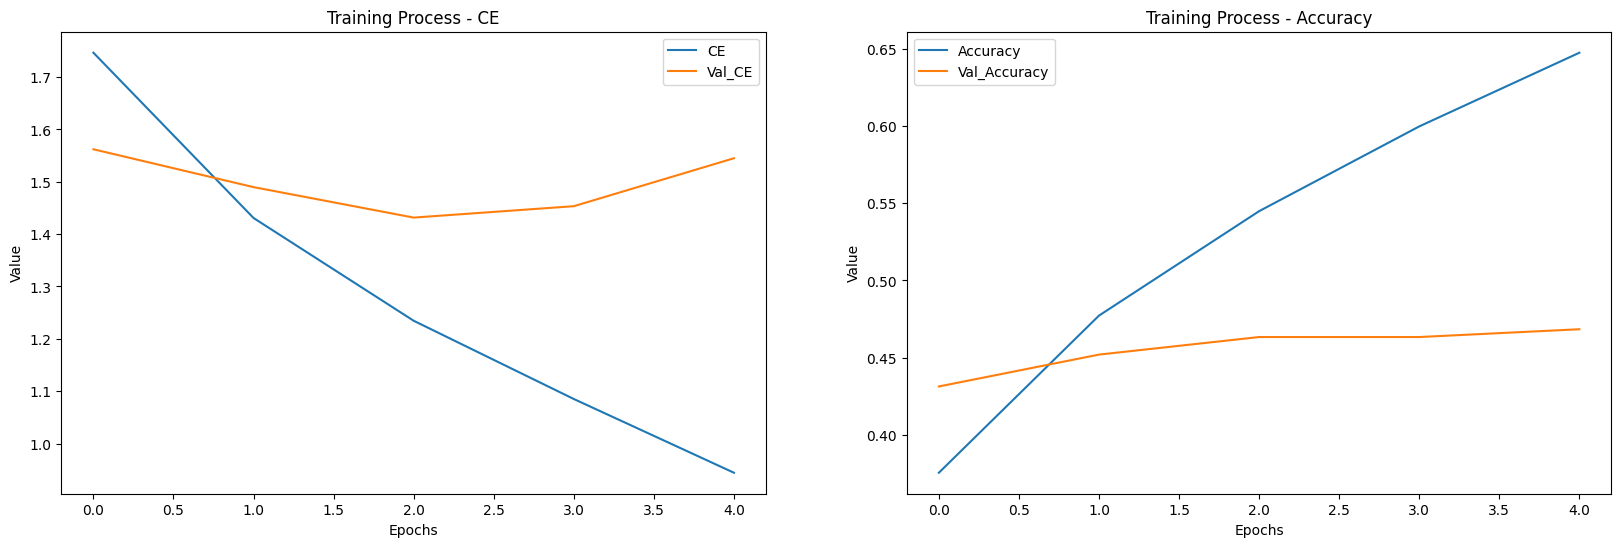

In [64]:
import matplotlib.pyplot as plt

fig, axis = plt.subplots(nrows=1,ncols=2, figsize=(20,6))

axis[0].plot(history.epoch, history.history['loss']) 
axis[0].plot(history.epoch, history.history['val_loss']) 
axis[0].set_xlabel("Epochs")
axis[0].set_ylabel("Value") 
axis[0].legend(["CE", "Val_CE"]) 
axis[0].set_title("Training Process - CE") 

axis[1].plot(history.epoch, history.history['accuracy'])
axis[1].plot(history.epoch, history.history['val_accuracy'])
axis[1].set_xlabel("Epochs") 
axis[1].set_ylabel("Value") 
axis[1].legend(["Accuracy", "Val_Accuracy"])
axis[1].set_title("Training Process - Accuracy")
plt.show()

Απαιτούνται 5 επαναλήψεις πριν γίνει overfitting. Τα βάρη του μοντέλου θα είναι αυτά της 3ης εποχής.

In [65]:
cnn_model.save('cnn-model-5-epochs.h5')

In [66]:
y_pred = cnn_model.predict(X_test_cnn)

159/159 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step


In [67]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

test_accuracy_cnn = accuracy_score(y_test_cnn.argmax(axis=1), y_pred.argmax(axis=1))

print("The Accuracy of the CNN Model on the test data is", test_accuracy_cnn)

The Accuracy of the CNN Model on the test data is 0.4750837108528659


**The accuracy achieved by CNN1D model is lower that the accuracy achieved by the LSTM model.**

In [69]:
print(classification_report(y_test_lstm.argmax(axis=1), y_pred.argmax(axis=1), 
                            target_names=['Action', 'Adventure', 'Comedy', 'Crime', 'Drama', 'Horror', 'Musical', 'Romance', 'Thriller', 'Western']))

              precision    recall  f1-score   support

      Action       0.43      0.20      0.27       329
   Adventure       0.50      0.04      0.07       158
      Comedy       0.50      0.46      0.48      1314
       Crime       0.34      0.08      0.13       170
       Drama       0.46      0.78      0.58      1789
      Horror       0.70      0.45      0.55       350
     Musical       0.00      0.00      0.00       140
     Romance       0.43      0.12      0.19       277
    Thriller       0.18      0.07      0.10       290
     Western       0.63      0.42      0.51       260

    accuracy                           0.48      5077
   macro avg       0.42      0.26      0.29      5077
weighted avg       0.46      0.48      0.43      5077



* The model achieves a fairly high recall for the Drama category – 78% of all observations belonging to this category are correctly predicted.
* On the other hand, the model has zero performance for the Musical category.
* The lowest recall is observed for the Adventure category.
* The highest accuracy is observed for the Horror category. The model is able to correctly predict 70% of the movies that it has assigned to this category.

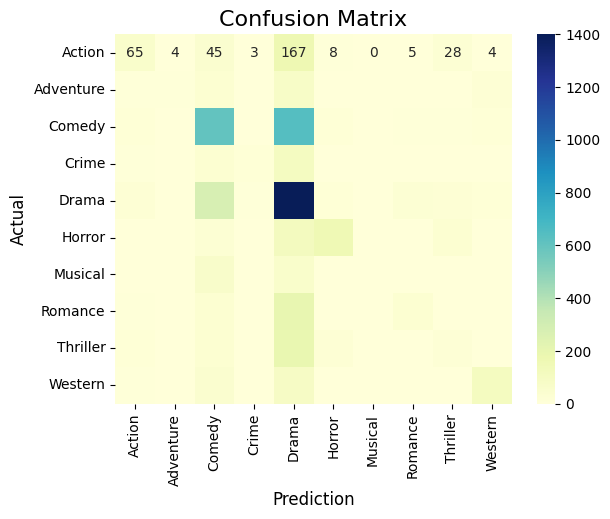

array([[  65,    4,   45,    3,  167,    8,    0,    5,   28,    4],
       [  10,    6,   35,    1,   78,    5,    0,    0,    1,   22],
       [  13,    0,  604,    5,  645,   14,    4,    8,    9,   12],
       [   7,    0,   35,   13,  107,    1,    0,    0,    4,    3],
       [  23,    1,  276,    9, 1400,   14,    0,   29,   22,   15],
       [   5,    0,   30,    1,  120,  159,    0,    0,   33,    2],
       [   0,    0,   71,    0,   64,    1,    0,    2,    0,    2],
       [   9,    0,   36,    0,  197,    0,    0,   34,    1,    0],
       [  11,    1,   35,    1,  193,   23,    0,    1,   21,    4],
       [   9,    0,   45,    5,   88,    3,    0,    0,    0,  110]],
      dtype=int64)

In [71]:
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test_cnn.argmax(axis=1), y_pred.argmax(axis=1))

sns.heatmap(cm, annot=True, fmt='d', cmap='YlGnBu', xticklabels=['Action', 'Adventure', 'Comedy', 'Crime', 'Drama', 'Horror', 'Musical', 'Romance', 'Thriller', 'Western'],
            yticklabels=['Action', 'Adventure', 'Comedy', 'Crime', 'Drama', 'Horror', 'Musical', 'Romance', 'Thriller', 'Western'])
plt.xlabel('Prediction',fontsize=12)
plt.ylabel('Actual',fontsize=12)
plt.title('Confusion Matrix',fontsize=16)
plt.show()

cm

## Multinomial Naive Bayes

We will use the simple Naive Bayes classifier for movie classification and then compare the results with the other two deep learning models. First, we will use the dataset that has undergone text cleaning techniques and split it into training and testing sets in the same manner.

Next, we will use the CountVectorizer from the sklearn.feature_extraction.text module to create a matrix where each row will represent a document (movie plot summary) and each column will represent a distinct word from the vocabulary. Each cell in the matrix will contain the frequency of a word in the respective document. We will use the 5000 most frequent words for this process.

In [72]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, shuffle=True, stratify=y)

print("Number of Observations in the Data set:" , X.values.shape[0]) 
print("Number of Observations in Train set:", X_train.shape[0])
print("Number of Observations in Test set:" , X_test.shape[0])   

Number of Observations in the Data set: 16923
Number of Observations in Train set: 11846
Number of Observations in Test set: 5077


In [73]:
X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

In [74]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(max_features=5000)

X_train_transformed = vectorizer.fit_transform(X_train)

X_test_transformed = vectorizer.transform(X_test)

The fit_transform method creates the numerical representation of each document from the train set. Therefore, the words in the vocabulary are based on the documents in the train set. The test set must also be converted into a numerical matrix according to the words in the vocabulary, and for this, the transform method is used.

In [81]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import StratifiedKFold
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report

nb_clf = MultinomialNB()

nb_clf.fit(X_train_transformed, y_train)

y_pred_nb = nb_clf.predict(X_test_transformed)

test_accuracy_nb = accuracy_score(y_test, y_pred_nb)
print("Accuracy:", test_accuracy_nb)
print("\nClassification Report:")
print(classification_report(y_test, y_pred_nb))

Accuracy: 0.5390978924561749

Classification Report:
              precision    recall  f1-score   support

      action       0.46      0.52      0.49       329
   adventure       0.35      0.65      0.46       158
      comedy       0.64      0.52      0.57      1314
       crime       0.30      0.49      0.37       170
       drama       0.66      0.51      0.57      1789
      horror       0.68      0.77      0.73       350
     musical       0.28      0.36      0.32       140
     romance       0.30      0.62      0.40       277
    thriller       0.31      0.26      0.28       290
     western       0.72      0.86      0.79       260

    accuracy                           0.54      5077
   macro avg       0.47      0.56      0.50      5077
weighted avg       0.58      0.54      0.55      5077



* The **overall accuracy** of the Bayes classifier is **53.9%.**
* The classifier shows the **highest recall for the Horror category**, correctly predicting 77% of the movies that actually belong to this category.
* For the Drama category, **the recall of the classifier is 51%, which is significantly lower than the recall of the previous models for this category.**
* The Bayes classifier achieves the **best performance for the Western category, with high recall and accuracy rates.**

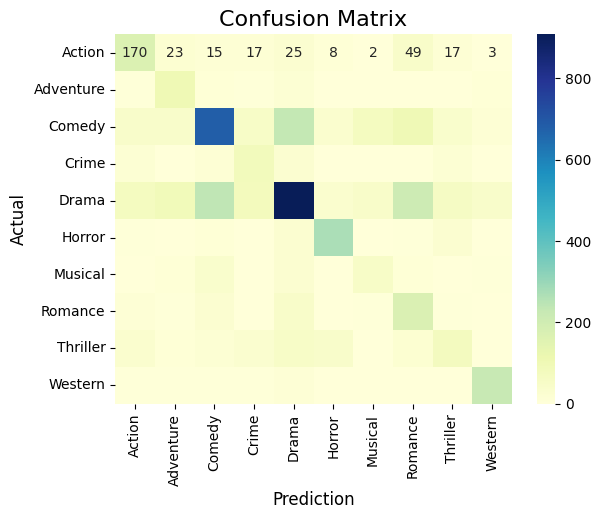

array([[170,  23,  15,  17,  25,   8,   2,  49,  17,   3],
       [  6, 103,   9,   6,  21,   3,   0,   0,   0,  10],
       [ 46,  46, 679,  51, 234,  33,  71, 102,  36,  16],
       [ 18,   2,  15,  84,  25,   3,   1,   1,  20,   1],
       [ 71,  89, 241,  81, 908,  33,  47, 210,  63,  46],
       [  4,   3,   9,   3,  25, 271,   3,   6,  26,   0],
       [  2,   8,  37,   3,  25,   0,  51,   8,   0,   6],
       [ 13,   4,  26,   1,  49,   1,   5, 171,   6,   1],
       [ 33,   8,  21,  31,  52,  43,   0,  24,  76,   2],
       [  4,   7,   6,   5,  11,   1,   2,   0,   0, 224]], dtype=int64)

In [89]:
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred_nb)

sns.heatmap(cm, annot=True, fmt='d', cmap='YlGnBu', xticklabels=['Action', 'Adventure', 'Comedy', 'Crime', 'Drama', 'Horror', 'Musical', 'Romance', 'Thriller', 'Western'],
            yticklabels=['Action', 'Adventure', 'Comedy', 'Crime', 'Drama', 'Horror', 'Musical', 'Romance', 'Thriller', 'Western'])
plt.xlabel('Prediction',fontsize=12)
plt.ylabel('Actual',fontsize=12)
plt.title('Confusion Matrix',fontsize=16)
plt.show()

cm

## Comparison between the results of the three models

In [90]:
result_df = pd.DataFrame(pd.Series([test_accuracy_lstm, test_accuracy_cnn, test_accuracy_nb],
                                   index=['LSTM Model', 'CNN Model', 'Naive Bayes Classifier']),
                         columns=['Accuracy']
                        )
result_df   

,Accuracy
LSTM Model,0.544613
CNN Model,0.475084
Naive Bayes Classifier,0.539098


We observe that the LSTM model achieves the highest overall accuracy, although there is not a significant deviation from the accuracy achieved by the simplistic Bayes classifier.

All three models have relatively good F-scores for the most popular category, Drama, with the LSTM model slightly outperforming the others.

The simplistic Bayes classifier shows the highest F-score for the Western category, meaning it will produce more reliable results compared to the other two models. It also achieves a higher F-score for the Horror and Action categories.

For the Comedy category, the most reliable results come from the LSTM model, followed by the Bayes classifier.

Therefore, we conclude that the LSTM model will predict the most popular category (Drama) more efficiently. The simplistic Bayes classifier performs better in the other categories (since its F-score does not fall below 30%).

The CNN model generally shows the weakest performance in comparison. However, it does not perform particularly poorly in the Drama and Horror categories.

## Predictions on new movie plots

In [104]:
plot = ["A dramatization of the life story of J. Robert Oppenheimer, the physicist who had a large hand in the development of the atomic bomb, thus helping end World War 2. We see his life from university days all the way to post-WW2, where his fame saw him embroiled in political machinations."]
seq = tokenizer.texts_to_sequences(plot)
padded = pad_sequences(seq, maxlen=500)

labels = ['Action', 'Adventure', 'Comedy', 'Crime', 'Drama', 'Horror', 'Musical', 'Romance', 'Thriller', 'Western']

pred_lstm = lstm_model.predict(padded)
print("LSTM Prediction:")
print(pred_lstm, labels[np.argmax(pred_lstm)])

pred_cnn = cnn_model.predict(padded)
print("\nCNN 1D Prediction:")
print(pred_cnn, labels[np.argmax(pred_cnn)])

plot_nb = vectorizer.transform(plot)
pred_nb = nb_clf.predict(plot_nb)
print("\nMultinomial Naive Bayes Prediction:")
print(f"Predicted Category: {pred_nb}\n")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
LSTM Prediction:
[[0.05418368 0.04078455 0.30450737 0.01898374 0.38013977 0.05957105
  0.00588342 0.01672722 0.1152906  0.00392857]] Drama
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step

CNN 1D Prediction:
[[0.0515506  0.01022508 0.14655714 0.03378003 0.6308824  0.03571334
  0.00274827 0.02912256 0.05370712 0.00571343]] Drama

Multinomial Naive Bayes Prediction:
Predicted Category: ['drama']



All three models correctly predicted the movie genre as Drama. The CNN 1D model gave a higher probability for this category compared to the LSTM model.

The LSTM model also assigned a fairly high probability that the movie belongs to the Comedy category – this likely happens because, from the Confusion Matrix, we can observe that the model categorizes a notable number of Drama category observations as Comedy.